# 🏎️ Analyzing Formula 1 Telemetry Data and Making Lap Time Predictions Using Machine Learning

## Introduction
Formula 1 racing combines speed, precision, and strategy, making it a fascinating arena for data analysis. In this tutorial, we will explore how to analyze Formula 1 telemetry data and predict lap times using machine learning techniques.

### Motivation

Suppose you work for a racing team and your strategy engineer wants to know in advance an estimate of what the driver's lap time will be

This notebook shows how to solve this problem.

![image.png](./images/sector-time.png)

By the end of this guide, you will understand how to:
- 📊 preprocess data
- 👨‍💻 engineer features 
- 🤖 train predictive models 
- 💯 interpret the results
 
All within the dynamic world of Formula 1 🏁



## Data Description
### Dataset Overview

- Provide a brief description of the dataset being used, including the source and key variables.
- Example: "The dataset includes telemetry data from various Formula 1 races, with variables such as speed, throttle position, gear, RPM, and lap time."

In [95]:
import fastf1
import ydf
import pandas as pd
import fastf1.plotting
import seaborn as sns
import numpy as np
import plotly.io as pio
import plotly.express as px

fastf1.plotting.setup_mpl(misc_mpl_mods=False)
pd.set_option('display.max_columns', None)
pio.renderers.default = "vscode"

### Variables and Data Sources

- List and describe the main variables in the dataset.
    - Example: "Speed (in km/h), Throttle Position (percentage), Gear (current gear), RPM (revolutions per minute), Lap Time (seconds)."
- Mention the source of the data.
    - Example: "The data is sourced from Kaggle Formula 1 Telemetry Dataset."

In [101]:
GRAND_PRIX = 'Imola'
YEAR = 2024
DRIVER = 'HAM'
SESSIONS = [
    # 'FP1', 
    # 'Sprint', 
    # 'Sprint Qualifying', 
    # 'Qualifying', 
    'Race'
]

### Data Preprocessing

- Placeholder for preprocessing steps.
    - Example: "Data cleaning, handling missing values, converting units if necessary, and normalizing features."

In [110]:
test_laps = pd.DataFrame()
all_laps = pd.DataFrame()
for session_name in SESSIONS:
    session = fastf1.get_session(YEAR, GRAND_PRIX, session_name)
    session.load(weather=False, messages=False)
    laps = session.laps
    drivers_lap = laps.pick_driver(DRIVER)
    if session_name == 'Race':
        # let's take the last 10 laps of the race to simulate at the end of the experiment
        # as if we were in the race
        test_laps = drivers_lap[-10:]
        drivers_lap = drivers_lap[:-10]
    all_laps = pd.concat([all_laps, drivers_lap], ignore_index=True)

all_laps.head(1).transpose()

core           INFO 	Loading data for Emilia Romagna Grand Prix - Race [v3.3.6]
INFO:fastf1.fastf1.core:Loading data for Emilia Romagna Grand Prix - Race [v3.3.6]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data

,0
Time,0 days 00:57:04.002000
Driver,HAM
DriverNumber,44
LapTime,0 days 00:01:27.111000
LapNumber,1.0
Stint,1.0
PitOutTime,NaT
PitInTime,NaT
Sector1Time,NaT
Sector2Time,0 days 00:00:29.112000


Some info about the data:
- **SpeedI1** (float): Speedtrap sector 1 [km/h]
- **SpeedI2** (float): Speedtrap sector 2 [km/h]
- **SpeedFL** (float): Speedtrap at finish line [km/h]
- **SpeedST** (float): Speedtrap on longest straight [km/h]
- All time related data is in `timedelta` format

We must drop the SpeedFL columns, since it's only obtained at the end of the lap. So its useless to lap time prediction.

Let's check if any lap was deleted

In [111]:
all_laps['Deleted'].count()

0

We can see that some data is useless for our experiment, like the lap number and the driver number. We will drop them to make our life easier

In [112]:
columns_in_timedelta = [
    'Time',
    'Sector1Time',
    'Sector2Time',
    'Sector3Time'
]

# all_laps_copy = all_laps.copy()
# test_laps_copy = test_laps.copy()
for col in columns_in_timedelta:
    col_total_seconds = all_laps[col].dt.total_seconds()
    all_laps[col] = None
    all_laps[col] = all_laps[col].astype(float)
    all_laps.loc[:, col] = col_total_seconds

    # col_total_seconds = test_laps_copy[col].dt.total_seconds()
    # test_laps_copy[col] = None
    # test_laps_copy[col] = test_laps_copy[col].astype(float)
    # test_laps_copy.loc[:, col] = col_total_seconds



# all_laps = all_laps_copy
# test_laps = test_laps_copy
# all_laps.describe().transpose()
all_laps

,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,Sector3Time,Sector1SessionTime,Sector2SessionTime,Sector3SessionTime,SpeedI1,SpeedI2,SpeedFL,SpeedST,IsPersonalBest,Compound,TyreLife,FreshTyre,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate
0,3424.002,HAM,44,0 days 00:01:27.111000,1.0,1.0,NaT,NaT,NaN,29.112,27.601,NaT,0 days 00:56:36.529000,0 days 00:57:04.177000,215.0,254.0,278.0,279.0,False,MEDIUM,1.0,True,Mercedes,0 days 00:55:36.608000,2024-05-19 13:03:16.594,1,7.0,None,,False,False
1,3505.843,HAM,44,0 days 00:01:21.841000,2.0,1.0,NaT,NaT,25.975,28.537,27.329,0 days 00:57:29.957000,0 days 00:57:58.494000,0 days 00:58:25.823000,NaN,254.0,278.0,280.0,True,MEDIUM,2.0,True,Mercedes,0 days 00:57:04.002000,2024-05-19 13:04:43.988,1,7.0,None,,False,True
2,3587.065,HAM,44,0 days 00:01:21.222000,3.0,1.0,NaT,NaT,25.398,28.589,27.235,0 days 00:58:51.221000,0 days 00:59:19.810000,0 days 00:59:47.045000,213.0,251.0,276.0,282.0,True,MEDIUM,3.0,True,Mercedes,0 days 00:58:25.843000,2024-05-19 13:06:05.829,1,7.0,None,,False,True
3,3668.780,HAM,44,0 days 00:01:21.715000,4.0,1.0,NaT,NaT,25.826,28.580,27.309,0 days 01:00:12.871000,0 days 01:00:41.451000,0 days 01:01:08.760000,215.0,252.0,276.0,282.0,False,MEDIUM,4.0,True,Mercedes,0 days 00:59:47.065000,2024-05-19 13:07:27.051,1,7.0,None,,False,True
4,3750.324,HAM,44,0 days 00:01:21.544000,5.0,1.0,NaT,NaT,25.532,28.695,27.317,0 days 01:01:34.292000,0 days 01:02:02.987000,0 days 01:02:30.304000,211.0,247.0,276.0,280.0,False,MEDIUM,5.0,True,Mercedes,0 days 01:01:08.780000,2024-05-19 13:08:48.766,1,7.0,None,,False,True
5,3831.893,HAM,44,0 days 00:01:21.569000,6.0,1.0,NaT,NaT,25.783,28.501,27.285,0 days 01:02:56.087000,0 days 01:03:24.588000,0 days 01:03:51.873000,213.0,253.0,276.0,284.0,False,MEDIUM,6.0,True,Mercedes,0 days 01:02:30.324000,2024-05-19 13:10:10.310,1,7.0,None,,False,True
6,3913.339,HAM,44,0 days 00:01:21.446000,7.0,1.0,NaT,NaT,25.820,28.323,27.303,0 days 01:04:17.693000,0 days 01:04:46.016000,0 days 01:05:13.319000,214.0,251.0,276.0,285.0,False,MEDIUM,7.0,True,Mercedes,0 days 01:03:51.893000,2024-05-19 13:11:31.879,1,7.0,None,,False,True
7,3994.932,HAM,44,0 days 00:01:21.593000,8.0,1.0,NaT,NaT,25.803,28.446,27.344,0 days 01:05:39.122000,0 days 01:06:07.568000,0 days 01:06:34.912000,212.0,249.0,277.0,284.0,False,MEDIUM,8.0,True,Mercedes,0 days 01:05:13.339000,2024-05-19 13:12:53.325,1,7.0,None,,False,True
8,4076.442,HAM,44,0 days 00:01:21.510000,9.0,1.0,NaT,NaT,25.861,28.431,27.218,0 days 01:07:00.773000,0 days 01:07:29.204000,0 days 01:07:56.422000,216.0,254.0,277.0,286.0,False,MEDIUM,9.0,True,Mercedes,0 days 01:06:34.932000,2024-05-19 13:14:14.918,1,7.0,None,,False,True
9,4157.986,HAM,44,0 days 00:01:21.544000,10.0,1.0,NaT,NaT,25.769,28.407,27.368,0 days 01:08:22.191000,0 days 01:08:50.598000,0 days 01:09:17.966000,213.0,255.0,277.0,283.0,False,MEDIUM,10.0,True,Mercedes,0 days 01:07:56.442000,2024-05-19 13:15:36.428,1,7.0,None,,False,True


In [116]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=all_laps["LapNumber"], y=all_laps["Sector1Time"],
                    mode='lines',
                    name='lines'))
fig.add_trace(go.Scatter(x=all_laps["LapNumber"], y=all_laps["Sector2Time"],
                    mode='lines+markers',
                    name='lines+markers'))
fig.add_trace(go.Scatter(x=all_laps["LapNumber"], y=all_laps["Sector3Time"],
                    mode='markers', name='markers'))

fig.show()

Se can see that there is a anomaly in the data since the safety car was deployed, this will hurt our model since these lap times are not relevant to the model. So let's drop those laps:

In [132]:
df = all_laps.drop(all_laps[(all_laps.LapNumber < 29) & (all_laps.LapNumber > 24)].index)

fig = go.Figure()
fig.add_trace(go.Scatter(x=df["LapNumber"], y=df["Sector1Time"],
                    hoverinfo='x+y',
                    stackgroup='one'))
fig.add_trace(go.Scatter(x=df["LapNumber"], y=df["Sector2Time"],
                    stackgroup='one'))
fig.add_trace(go.Scatter(x=df["LapNumber"], y=df["Sector3Time"],
                    stackgroup='one'))

fig.show()

In [103]:
columns_to_drop = [
    'LapTime',
    'Time',
    'LapNumber',
    'Driver',
    'DriverNumber',
    'Sector1SessionTime',
    'Sector2SessionTime',
    'Sector3SessionTime',
    'PitInTime',
    'PitOutTime',
    'Team',
    'Position',
    'LapStartTime',
    'LapStartDate',
    'IsPersonalBest',
    'Deleted',
    'DeletedReason',
    'FastF1Generated',
    'IsAccurate',
    'SpeedFL',
    'SpeedST'
]

all_laps = all_laps.drop(columns_to_drop, axis=1)
all_laps.head(1).transpose()

,0
Stint,1.0
Sector1Time,NaT
Sector2Time,0 days 00:00:29.112000
Sector3Time,0 days 00:00:27.601000
SpeedI1,215.0
SpeedI2,254.0
Compound,MEDIUM
TyreLife,1.0
FreshTyre,True
TrackStatus,1


### Clean the data

The dataset contains a few unknown values:

In [104]:
all_laps.isna().sum()

Stint          0
Sector1Time    1
Sector2Time    0
Sector3Time    0
SpeedI1        8
SpeedI2        0
Compound       0
TyreLife       0
FreshTyre      0
TrackStatus    0
dtype: int64

Drop those rows to keep this initial tutorial simple:

In [105]:
all_laps.dropna(inplace=True)
all_laps.isna().sum()

Stint          0
Sector1Time    0
Sector2Time    0
Sector3Time    0
SpeedI1        0
SpeedI2        0
Compound       0
TyreLife       0
FreshTyre      0
TrackStatus    0
dtype: int64

Some columns represent the time in `timedelta` format, let's convert them to seconds

In [108]:

columns_in_timedelta = [
    'Sector1Time',
    'Sector2Time',
    'Sector3Time'
]

all_laps_copy = all_laps.copy()
test_laps_copy = test_laps.copy()
for col in columns_in_timedelta:
    col_total_seconds = all_laps_copy[col].dt.total_seconds()
    all_laps_copy[col] = None
    all_laps_copy[col] = all_laps_copy[col].astype(float)
    all_laps_copy.loc[:, col] = col_total_seconds

    col_total_seconds = test_laps_copy[col].dt.total_seconds()
    test_laps_copy[col] = None
    test_laps_copy[col] = test_laps_copy[col].astype(float)
    test_laps_copy.loc[:, col] = col_total_seconds



all_laps = all_laps_copy
test_laps = test_laps_copy
all_laps.describe().transpose()
all_laps

AttributeError: Can only use .dt accessor with datetimelike values

In [81]:
test_laps['Sector3Time'].values

array([25.723, 25.601, 25.713, 25.636, 25.608, 25.62 , 25.679, 25.65 ,
       25.741, 25.701])

<Axes: xlabel='Stint', ylabel='Sector3Time'>

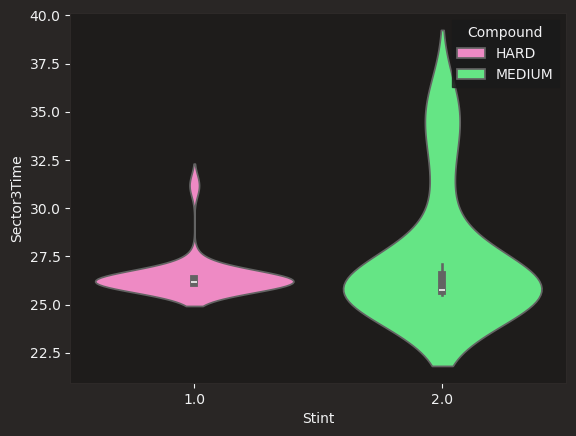

In [82]:
import matplotlib.pyplot as plt

# fig, axs = plt.subplots(ncols=5, figsize=(30,5))
# sns.displot(data=all_laps, x="Sector1Time", hue="Compound", kde=True)
# sns.displot(data=all_laps, x="Sector2Time", hue="Compound", kde=True)
# sns.displot(data=all_laps, x="Sector3Time", hue="Compound", kde=True)
# sns.pointplot(data=all_laps, x="TyreLife", y="Sector3Time", hue="Compound")
sns.violinplot(data=all_laps, x="Stint", y="Sector3Time", hue="Compound")


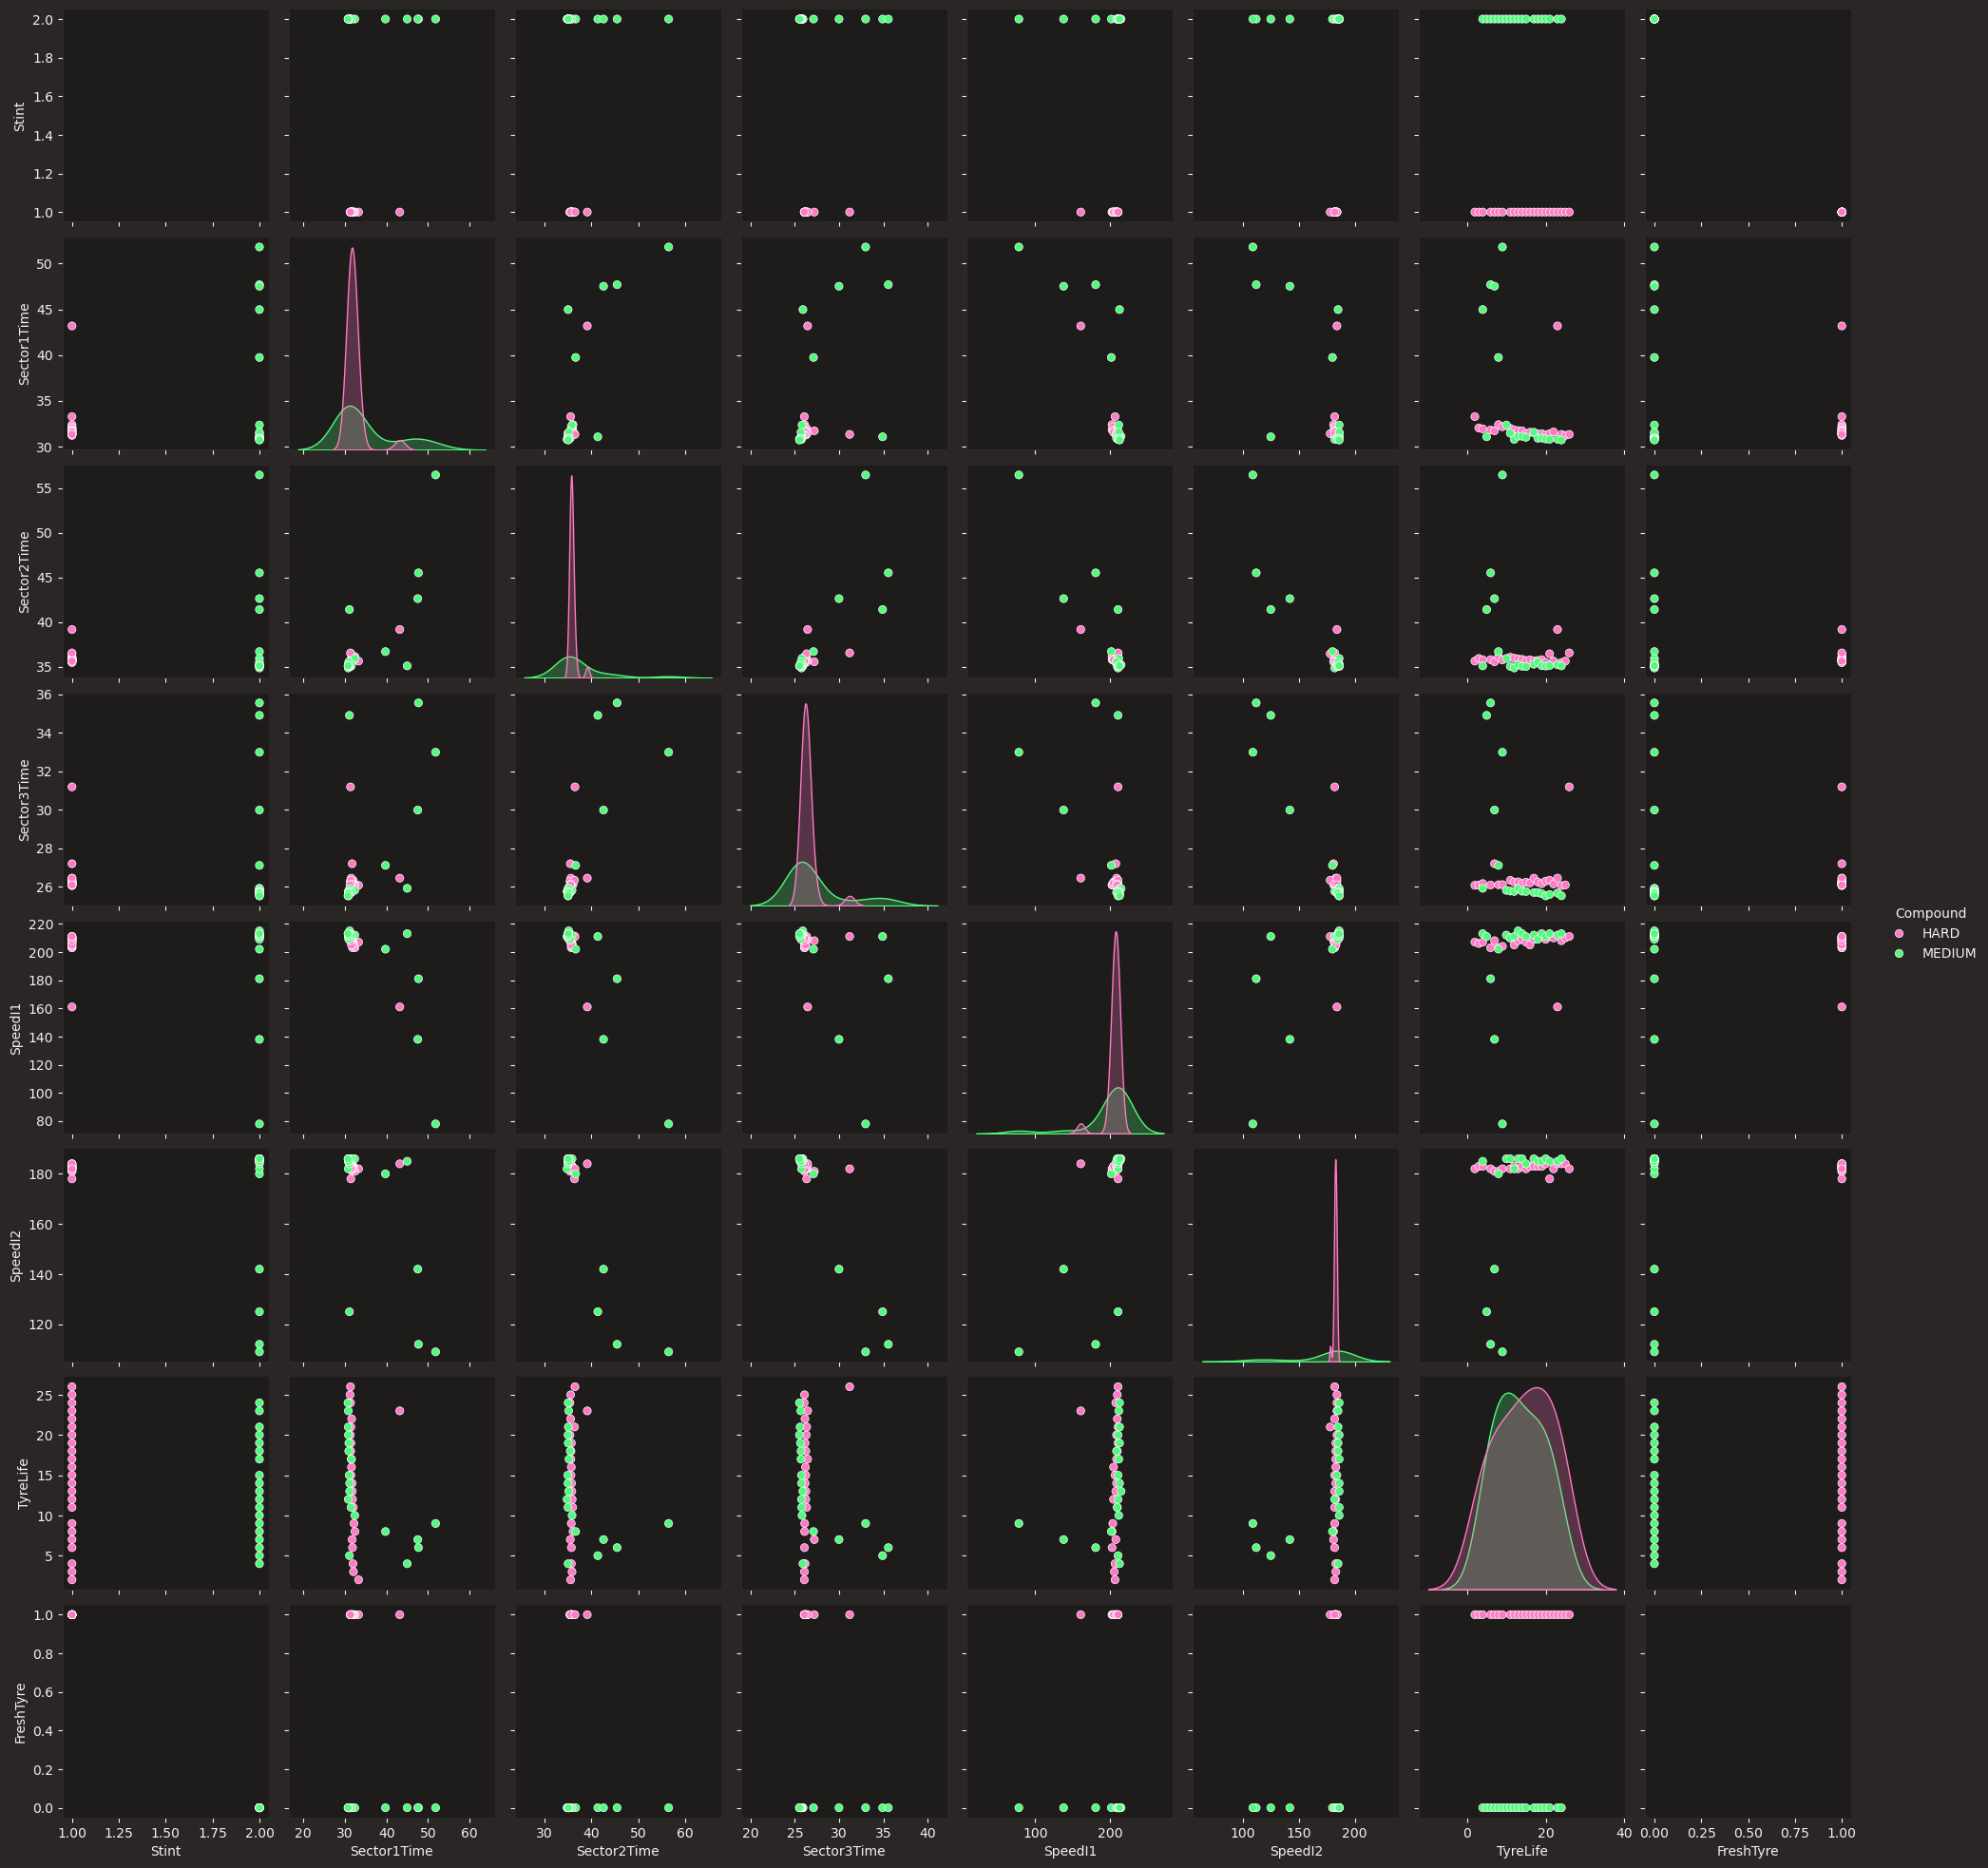

In [83]:
sns.pairplot(all_laps, hue="Compound")

In [81]:
# Use the ~10% of the examples as the testing set
# and the remaining ~90% of the examples as the training set.

# np.random.seed(1)
# is_test = np.random.rand(len(all_laps)) < 0.3

# train_ds = all_laps[~is_test]
# test_ds = all_laps[is_test]

# print(len(train_ds), len(test_ds))

83 40


In [84]:
model = ydf.GradientBoostedTreesLearner(label="Sector3Time",
                                task=ydf.Task.REGRESSION).train(all_laps)

Train model on 42 examples
Model trained in 0:00:00.032711


In [85]:
evaluation = model.evaluate(test_laps)

print(evaluation)

RMSE: 0.331636
num examples: 10
num examples (weighted): 10



In [86]:
# import plotly.io as pio
# pio.renderers.default = "notebook"
# pio.renderers.default = "notebook_connected"
evaluation

Evaluation()

In [87]:
model.analyze(test_laps)

In [88]:
y = test_laps['Sector3Time'].values
y

array([25.723, 25.601, 25.713, 25.636, 25.608, 25.62 , 25.679, 25.65 ,
       25.741, 25.701])

In [89]:
y_hat = np.round(model.predict(test_laps), decimals=3)
y_hat

array([25.993, 25.963, 26.002, 26.002, 26.017, 25.993, 25.97 , 25.993,
       26.032, 25.993], dtype=float32)

In [90]:
error = np.around(y_hat - y, decimals=3)
error

array([0.27 , 0.362, 0.289, 0.366, 0.409, 0.373, 0.291, 0.343, 0.291,
       0.292])

In [91]:
error.mean()

0.32859999999999995

In [28]:
pio.renderers.default = "vscode"
# pio.renderers
model.plot_tree()

In [61]:
model.describe()